In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers #Installing Huggingface transformers 

     |████████████████████████████████| 1.4MB 5.9MB/s 
     |████████████████████████████████| 2.9MB 47.0MB/s 
     |████████████████████████████████| 890kB 52.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=b8dcb3ad28ebce59f03fac1836846a94978fe76ea64b78227023da1748ce4a7f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
import os
import requests
import tempfile
import zipfile
import shutil
import json
import time
import sys
import cv2
import numpy as np
import pandas as pd
from glob import glob
import subprocess
import matplotlib.pyplot as plt
import re
import string
%matplotlib inline


import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Embedding, Dense, GRU
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from keras.utils.layer_utils import count_params
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from transformers import BertTokenizer, TFBertForSequenceClassification, TFBertModel

#import tensorflow_model_optimization as tfmot
#from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score

# Read data

In [24]:
data = pd.read_excel('/content/drive/MyDrive/AC295 Final Proj/data/training_set_rel3.xls')
data = data[~np.isnan(data['domain1_score'].values)]

**As mentioned in milestone3, classification is not appropriate when we have large number of score levels. Instead of doing classification, we try regression. In this way, we can combine essays from all prompts. We rescale the scores to [0, 1] to train the model, then rescale back to examine performance of models (quadratic weighted kappa).**

# scaling

In [25]:
low_scale={1:2,2:1,3:0,4:0,5:0,6:0,7:0,8:0}
high_scale={1:12,2:6,3:3,4:3,5:4,6:4,7:30,8:60}

In [26]:
data['low_scale']=data.essay_set.map(low_scale)
data['high_scale']=data.essay_set.map(high_scale)
data['scaled_score']=(data.domain1_score-data.low_scale)/(data.high_scale-data.low_scale)

In [27]:
data

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6,low_scale,high_scale,scaled_score
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,0.600000
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,0.700000
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,0.500000
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,0.800000
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12973,21626,8,In most stories mothers and daughters are eit...,17.0,18.0,NaN,35.0,NaN,NaN,NaN,4.0,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,0,60,0.583333
12974,21628,8,I never understood the meaning laughter is th...,15.0,17.0,NaN,32.0,NaN,NaN,NaN,3.0,3.0,4.0,3.0,3.0,3.0,4.0,3.0,4.0,4.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,0,60,0.533333
12975,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",20.0,26.0,40.0,40.0,NaN,NaN,NaN,4.0,4.0,4.0,4.0,4.0,4.0,6.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,0,60,0.666667
12976,21630,8,Trippin' on fen...,20.0,20.0,NaN,40.0,NaN,NaN,NaN,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0,60,0.666667


# Divide data by prompt    
To allow the models to recognize essays from other prompts, we randomly add some essays from other prompts and set those score to be 0, as some adversial samples. The number of adversial samples is roughly half of the original prompt subset, and these adversial samples are evenly sampled from the other 7 prompts.

In [41]:
data_dict={}
data_X={}
data_y={}
data_y_origin={}
essay_set_dict={}
for i in range(1,9):
  data_dict[i]=data[data.essay_set == i]
  data_add=data[data.essay_set != i].groupby('essay_set').sample(n=int(len(data_dict[i])/(7*2)))
  data_add.scaled_score=0
  data_add.domain1_score=0
  data_dict[i]=data_dict[i].append(data_add)
  data_X[i]=data_dict[i].essay.values
  data_y[i]=data_dict[i].scaled_score.values.reshape(-1,1)
  data_y_origin[i]=data_dict[i].domain1_score.values.reshape(-1,1)
  essay_set_dict[i]=data_dict[i].essay_set.values.reshape(-1,1)


In [44]:
for data in data_dict.values():
  print(len(data))

2672
2696
2587
2653
2701
2696
2353
1080


In [45]:
train={}
train_aux={}

val={}
val_aux={}

for i in range(1,9):
  train_X, test_X, train_y, test_y, train_y_origin, test_y_origin, train_essay_set, test_essay_set = train_test_split(data_X[i], data_y[i], data_y_origin[i], essay_set_dict[i], test_size = 0.2, random_state = 295, stratify=data_dict[i].essay_set)
  train[i]=(train_X, train_y)
  train_aux[i]=(train_y_origin,train_essay_set)
  val[i]=(test_X, test_y)
  val_aux[i]=(test_y_origin,test_essay_set)

In [10]:
def wordcount(seq):
  words = seq.split(' ')
  return len(words)
data.essay.map(wordcount).max()

1119

In [46]:
train[1]

(array(['Dear Local Newspaper, @CAPS1! I am an @NUM1 grade student at @PERSON1. I was reading your paper and I notice you had an article on how people are spending too much time on the computer and not enough time going outside, getting exercise, enjoying nature, and that it doesn\'t benifit society. i completly disagree with these comments. let me explain... Having computers definatly benifits for all students. Sometimes kids forget their text books at school. But if they have a computer, they can just google the information. That way they get there homework done, and don\'t have to take a zero. Another thing is, I am sure you have heard of a website called, study island. If you havn\'t, i\'ts a website for all the students in the @LOCATION1 to take online courses for math, reading, and science. They are time consuming, but they count for a huge chunk of our grade. So, if we get an @CAPS2 on study island we get an @CAPS2 in one of our classes.. Not only does the computer help students

# Tokenization

In [48]:
max_features = 15000
sequence_length = 1200

text_data = tf.data.Dataset.from_tensor_slices(data.essay.values)

text_vectorizer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

text_vectorizer.adapt(text_data.batch(64))

def vectorize_text(text, label=None):
  text = tf.expand_dims(text, -1)
  text = text_vectorizer(text)
  if label is None:
    return text
  else:
    return text, label

In [53]:
batch_size = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data={}
val_data={}

for i in range(1,9):
  train_data[i] = tf.data.Dataset.from_tensor_slices(train[i])
  train_data[i] = train_data[i].batch(batch_size)
  train_data[i] = train_data[i].cache().prefetch(buffer_size=100)

  val_data[i] = tf.data.Dataset.from_tensor_slices(val[i])
  val_data[i] = val_data[i].batch(batch_size)
  val_data[i] = val_data[i].cache().prefetch(buffer_size=100)

In [56]:
train_data

{1: <PrefetchDataset shapes: ((None,), (None, 1)), types: (tf.string, tf.float64)>,
 2: <PrefetchDataset shapes: ((None,), (None, 1)), types: (tf.string, tf.float64)>,
 3: <PrefetchDataset shapes: ((None,), (None, 1)), types: (tf.string, tf.float64)>,
 4: <PrefetchDataset shapes: ((None,), (None, 1)), types: (tf.string, tf.float64)>,
 5: <PrefetchDataset shapes: ((None,), (None, 1)), types: (tf.string, tf.float64)>,
 6: <PrefetchDataset shapes: ((None,), (None, 1)), types: (tf.string, tf.float64)>,
 7: <PrefetchDataset shapes: ((None,), (None, 1)), types: (tf.string, tf.float64)>,
 8: <PrefetchDataset shapes: ((None,), (None, 1)), types: (tf.string, tf.float64)>}

# Utils functions

In [58]:
def evaluate_model(model,test_data, training_results):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('MSE')
  # Plot all metrics
  for metric in ["mse","val_mse"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print("Evaluation Results:", evaluation_results)

In [133]:
def QWK(model, i):
  #calculate quadratic weighted kappa
  df=pd.DataFrame(model.predict(val_data[i]),columns=['pred_scaled'])
  df['true_scaled']=val[i][1]
  df['essay_set']=val_aux[i][1]
  df['low_scale']=df.essay_set.map(low_scale)
  df['high_scale']=df.essay_set.map(high_scale)
  df['pred_origin']=df['pred_scaled']*(df.high_scale-df.low_scale)+df.low_scale
  df['pred_origin_rounded']=df['pred_origin'].round(0).astype(int)
  df['true_origin']=val_aux[i][0]
  df_i=df[df.essay_set==i]
  df_ni=df[df.essay_set!=i]
  
  QWK=cohen_kappa_score(df_i['pred_origin_rounded'], df_i['true_origin'], weights='quadratic')
  
  return QWK, df_i, df_ni


In [134]:
def QWK_bert(model,i):
  #calculate quadratic weighted kappa
  df=pd.DataFrame(model.predict(val_data_bert[i]),columns=['pred_scaled'])
  df['true_scaled']=val[i][1]
  df['essay_set']=val_aux[i][1]
  df['low_scale']=df.essay_set.map(low_scale)
  df['high_scale']=df.essay_set.map(high_scale)
  df['pred_origin']=df['pred_scaled']*(df.high_scale-df.low_scale)+df.low_scale
  df['pred_origin_rounded']=df['pred_origin'].round(0).astype(int)
  df['true_origin']=val_aux[i][0]
  df_i=df[df.essay_set==i]
  df_ni=df[df.essay_set!=i]

  QWK=cohen_kappa_score(df_i['pred_origin_rounded'], df_i['true_origin'], weights='quadratic')
  return QWK, df_i, df_ni


# Building models

## 1. FFNN model

Training for prompt 1......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                76864     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 79,489
Trainable params: 79,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
34/34 [==============================] - 1s 16ms/step - loss: 108.9583 - mse: 

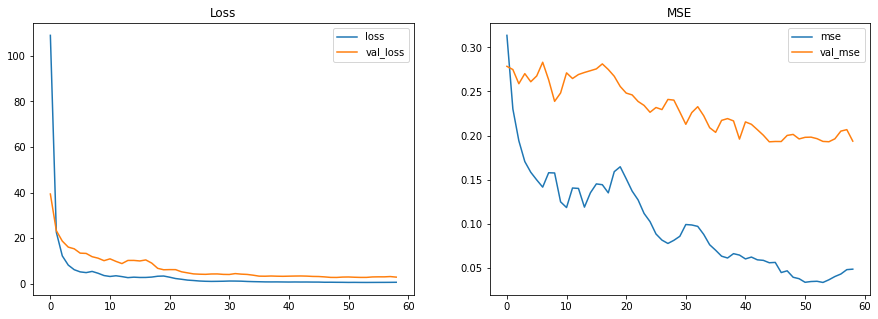

9/9 [==============================] - 0s 7ms/step - loss: 2.7399 - mse: 0.2013
Evaluation Results: [2.7399415969848633, 0.2012573629617691]
Finished for prompt 1
##################################################
Training for prompt 2......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                76864     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params

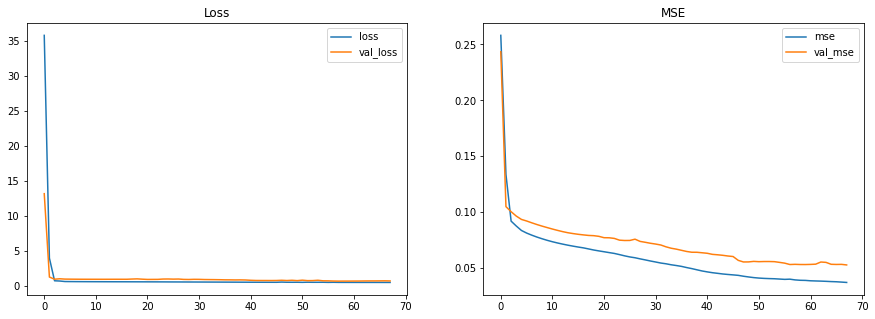

9/9 [==============================] - 0s 7ms/step - loss: 0.7208 - mse: 0.0534
Evaluation Results: [0.7207616567611694, 0.05341498553752899]
Finished for prompt 2
##################################################
Training for prompt 3......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                76864     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total param

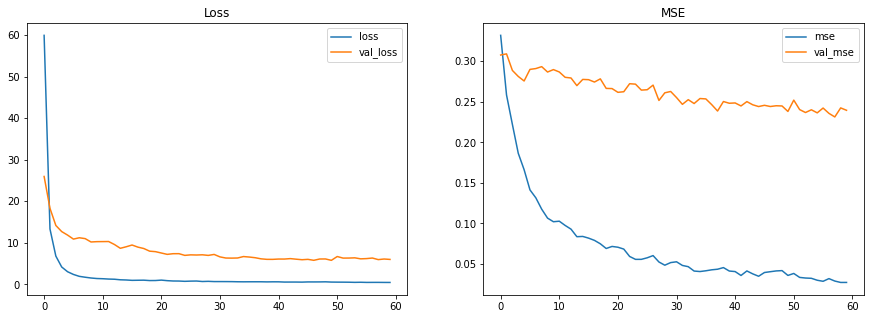

9/9 [==============================] - 0s 5ms/step - loss: 5.7837 - mse: 0.2381
Evaluation Results: [5.783728122711182, 0.23810139298439026]
Finished for prompt 3
##################################################
Training for prompt 4......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                76864     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params

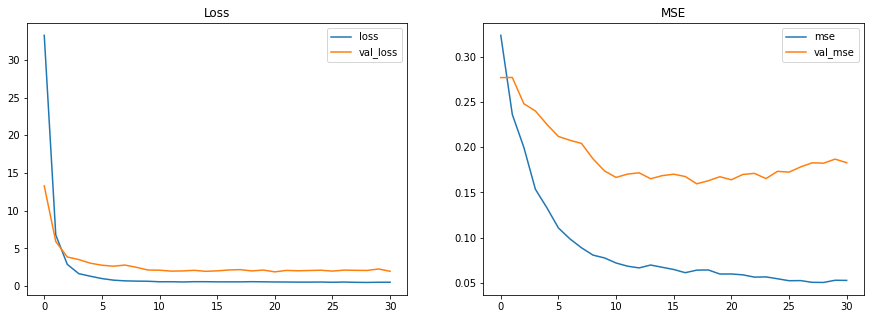

9/9 [==============================] - 0s 5ms/step - loss: 1.8992 - mse: 0.1639
Evaluation Results: [1.8992149829864502, 0.16390658915042877]
Finished for prompt 4
##################################################
Training for prompt 5......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                76864     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total param

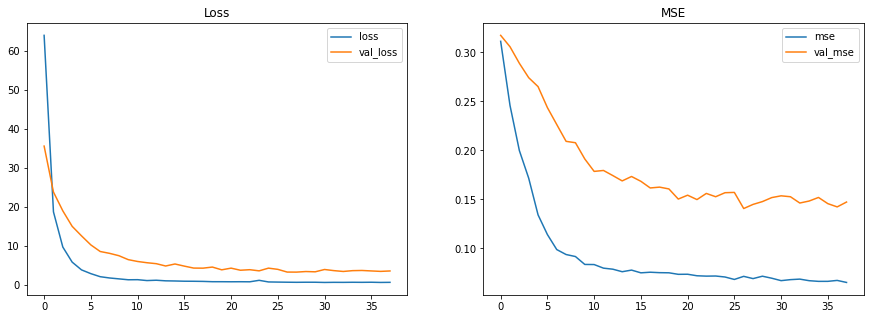

9/9 [==============================] - 0s 5ms/step - loss: 3.3048 - mse: 0.1449
Evaluation Results: [3.3048207759857178, 0.14493288099765778]
Finished for prompt 5
##################################################
Training for prompt 6......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                76864     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total param

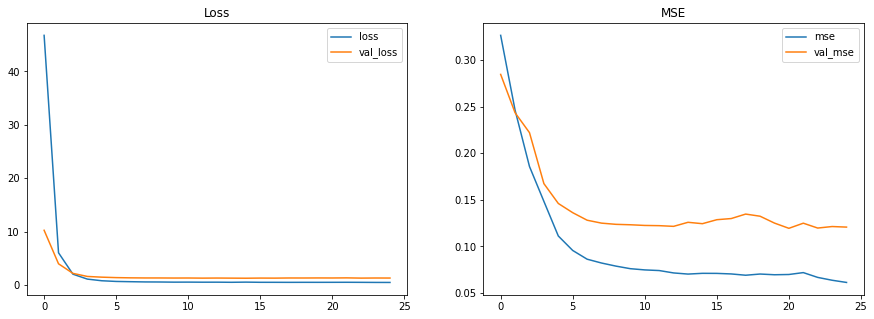

9/9 [==============================] - 0s 7ms/step - loss: 1.2854 - mse: 0.1244
Evaluation Results: [1.2854034900665283, 0.12437134981155396]
Finished for prompt 6
##################################################
Training for prompt 7......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                76864     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total param

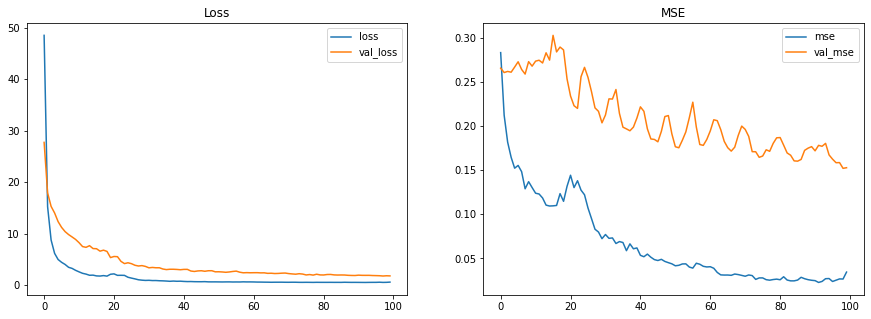

8/8 [==============================] - 0s 5ms/step - loss: 1.7855 - mse: 0.1528
Evaluation Results: [1.785470724105835, 0.1527509093284607]
Finished for prompt 7
##################################################
Training for prompt 8......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                76864     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params:

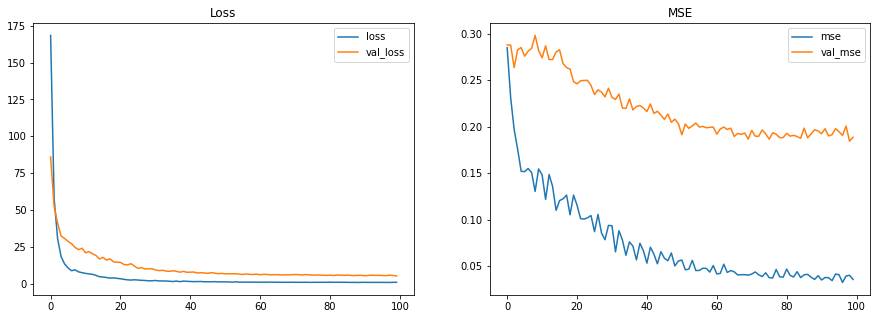

4/4 [==============================] - 0s 9ms/step - loss: 5.1299 - mse: 0.1886
Evaluation Results: [5.129892349243164, 0.18859614431858063]
Finished for prompt 8
##################################################


In [63]:
model_ffnn={}
history_ffnn={}
for i in range(1,9):
  print('Training for prompt '+str(i)+'......')
  K.clear_session()
  model_ffnn[i] = Sequential()
  model_ffnn[i].add(layers.Input(shape = (1,),dtype=tf.string))
  model_ffnn[i].add(text_vectorizer)
  model_ffnn[i].add(layers.Dense(64, activation = 'relu'))
  model_ffnn[i].add(layers.Dense(32, activation = 'relu'))
  model_ffnn[i].add(layers.Dense(16, activation = 'relu'))
  model_ffnn[i].add(layers.Dense(1, activation = 'sigmoid')) # scaled score in [0, 1]
  model_ffnn[i].summary()

  loss = tf.keras.losses.binary_crossentropy
  optimizer = optimizers.Adam(lr = 0.001)
  metrics=['mse']
  model_ffnn[i].compile(loss= loss, optimizer = optimizer, metrics = metrics)

  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', restore_best_weights=True
)
  
  history_ffnn[i]=model_ffnn[i].fit(train_data[i], validation_data = val_data[i], callbacks=early_stopping, epochs = 100, verbose = 1)
  evaluate_model(model_ffnn[i],val_data[i],history_ffnn[i])
  print('Finished for prompt '+str(i))
  print('#'*50)






In [68]:
for i in range(1,9):
  print(QWK(model_ffnn[i],i)[0])

0.06286898087784165
0.31543624161073824
0.06268029413513021
0.14370550038709917
0.0941483488908963
0.20067286993141908
-0.04159969245991335
0.022320714262856534


## 2. Embedding + LSTM

Training for prompt 1......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 200)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               120400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,120,501
Trainable params: 3,120,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
34/34 [==============================] - 5s 135ms/step - loss: 0.5905 - mse: 0.0715 - val_loss: 0.4604 - val_mse: 0.0224
Epoch 2/50
34/34 [==============================] - 3s 96ms/step - loss: 0.4541 - ms

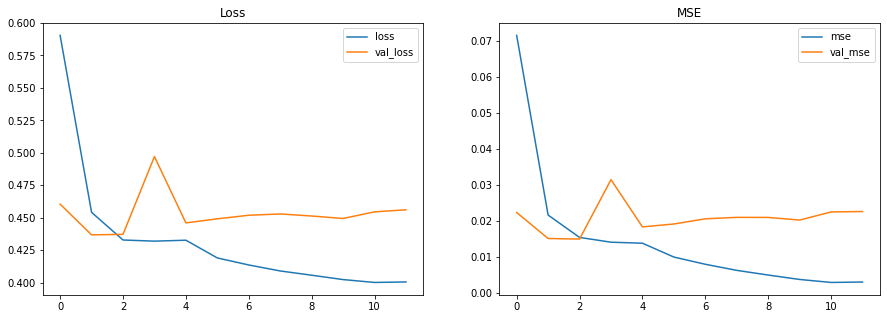

9/9 [==============================] - 0s 30ms/step - loss: 0.4367 - mse: 0.0152
Evaluation Results: [0.4367328882217407, 0.015150141902267933]
Finished for prompt 1
##################################################
Training for prompt 2......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 200)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               120400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,120,501
Trainable params: 3,120,501
Non-trainable params: 0
_________________________________________________________________

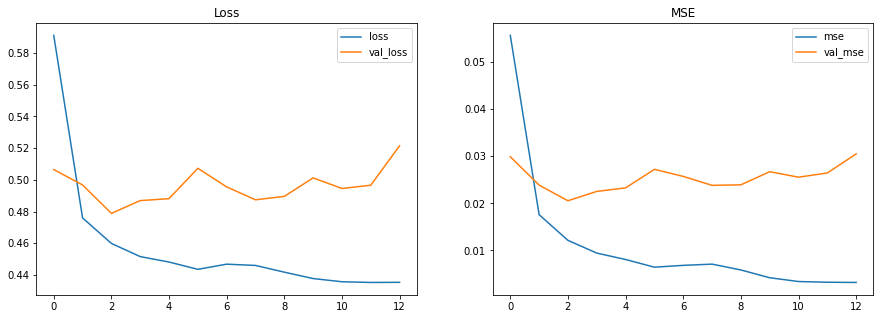

9/9 [==============================] - 0s 31ms/step - loss: 0.4789 - mse: 0.0205
Evaluation Results: [0.47885990142822266, 0.020545249804854393]
Finished for prompt 2
##################################################
Training for prompt 3......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 200)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               120400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,120,501
Trainable params: 3,120,501
Non-trainable params: 0
________________________________________________________________

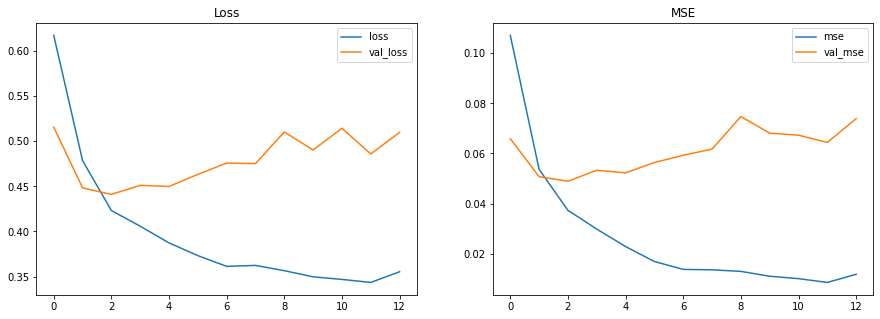

9/9 [==============================] - 0s 27ms/step - loss: 0.4410 - mse: 0.0489
Evaluation Results: [0.44103020429611206, 0.04889066517353058]
Finished for prompt 3
##################################################
Training for prompt 4......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 200)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               120400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,120,501
Trainable params: 3,120,501
Non-trainable params: 0
_________________________________________________________________

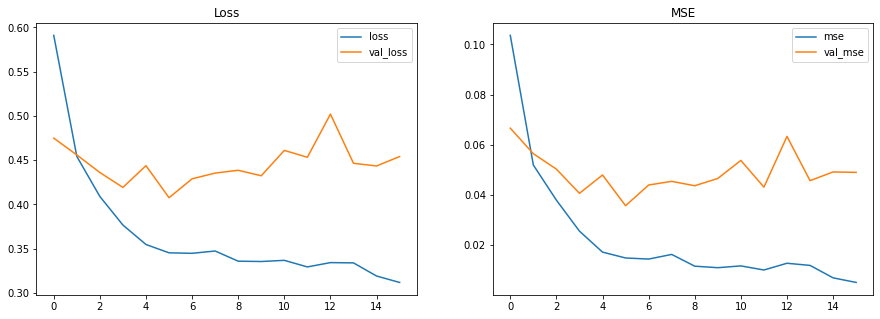

9/9 [==============================] - 0s 30ms/step - loss: 0.4077 - mse: 0.0357
Evaluation Results: [0.4076569676399231, 0.03572525456547737]
Finished for prompt 4
##################################################
Training for prompt 5......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 200)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               120400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,120,501
Trainable params: 3,120,501
Non-trainable params: 0
_________________________________________________________________


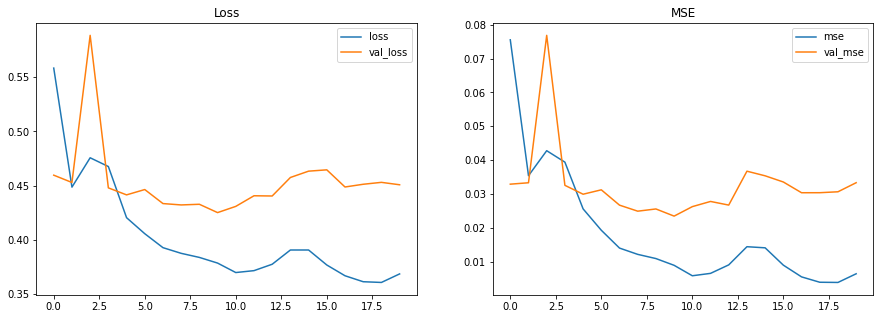

9/9 [==============================] - 0s 28ms/step - loss: 0.4251 - mse: 0.0234
Evaluation Results: [0.42509695887565613, 0.023433035239577293]
Finished for prompt 5
##################################################
Training for prompt 6......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 200)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               120400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,120,501
Trainable params: 3,120,501
Non-trainable params: 0
________________________________________________________________

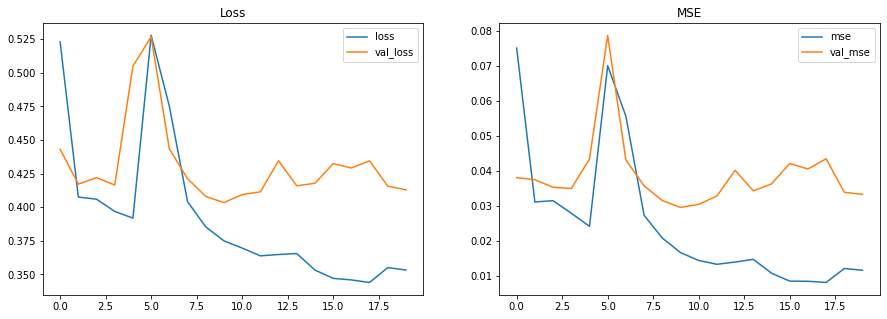

9/9 [==============================] - 0s 27ms/step - loss: 0.4035 - mse: 0.0296
Evaluation Results: [0.4034913182258606, 0.029621455818414688]
Finished for prompt 6
##################################################
Training for prompt 7......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 200)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               120400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,120,501
Trainable params: 3,120,501
Non-trainable params: 0
_________________________________________________________________

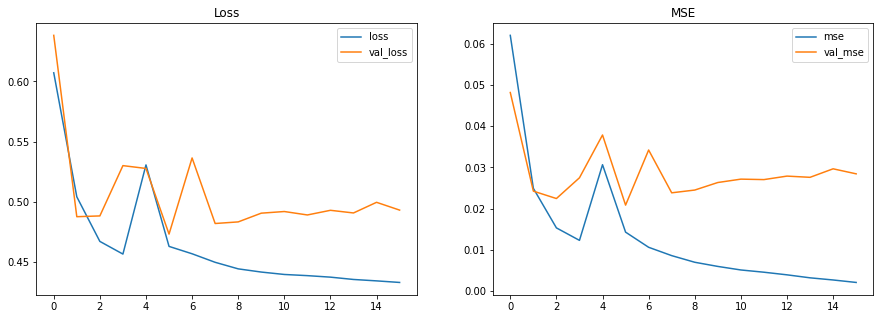

8/8 [==============================] - 0s 28ms/step - loss: 0.4731 - mse: 0.0209
Evaluation Results: [0.4731195867061615, 0.020862191915512085]
Finished for prompt 7
##################################################
Training for prompt 8......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 200)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               120400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,120,501
Trainable params: 3,120,501
Non-trainable params: 0
_________________________________________________________________

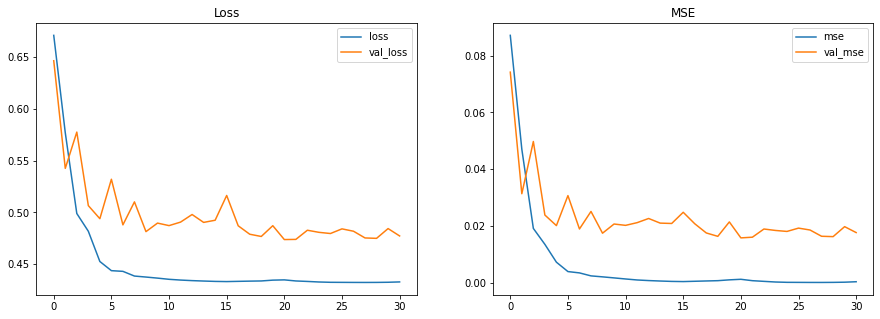

4/4 [==============================] - 0s 25ms/step - loss: 0.4737 - mse: 0.0158
Evaluation Results: [0.4737391769886017, 0.015840768814086914]
Finished for prompt 8
##################################################


In [77]:
model_em_lstm={}
history_em_lstm={}
for i in range(1,9):
  print('Training for prompt '+str(i)+'......') 
  K.clear_session()
  latent_dim=200

  model_em_lstm[i]=Sequential()
  model_em_lstm[i].add(layers.Input(shape = (1,),dtype=tf.string))
  model_em_lstm[i].add(text_vectorizer)
  model_em_lstm[i].add(Embedding(max_features, latent_dim, input_length=sequence_length, mask_zero=True))
  model_em_lstm[i].add(LSTM(100))
  model_em_lstm[i].add(layers.Dense(1, activation = 'sigmoid'))

  model_em_lstm[i].summary()
  loss = tf.keras.losses.binary_crossentropy
  optimizer = optimizers.Adam(lr = 0.001)
  metrics=['mse']
  model_em_lstm[i].compile(loss= loss, optimizer = optimizer, metrics = metrics)

  early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto',restore_best_weights=True
  )

  history_em_lstm[i]=model_em_lstm[i].fit(train_data[i], validation_data = val_data[i], callbacks=early_stopping, epochs = 50, verbose = 1)
  evaluate_model(model_em_lstm[i],val_data[i],history_em_lstm[i])

  print('Finished for prompt '+str(i)) 
  print('#'*50)

In [78]:
for i in range(1,9):
  print(QWK(model_em_lstm[i],i)[0])

0.09899336971341821
0.08873576149627327
0.15905573929665917
0.6268447016214642
0.612892112860574
0.4554201411161002
0.022320912564998796
0.25877560754206064


## 3. Embedding + GRU

Training for prompt 1......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 200)         3000000   
_________________________________________________________________
gru (GRU)                    (None, 100)               90600     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,090,701
Trainable params: 3,090,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
34/34 [==============================] - 4s 130ms/step - loss: 0.6290 - mse: 0.0865 - val_loss: 0.5824 - val_mse: 0.0639
Epoch 2/100
34/34 [==============================] - 3s 95ms/step - loss: 0.5024 - 

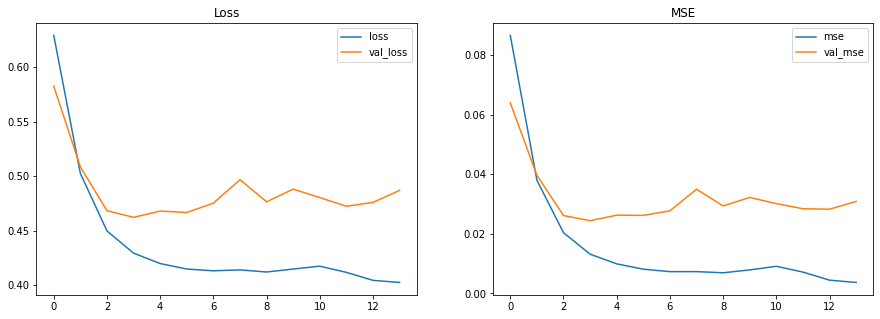

9/9 [==============================] - 0s 30ms/step - loss: 0.4621 - mse: 0.0244
Evaluation Results: [0.4620765745639801, 0.024389706552028656]
Finished for prompt 1
##################################################
Training for prompt 2......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 200)         3000000   
_________________________________________________________________
gru (GRU)                    (None, 100)               90600     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,090,701
Trainable params: 3,090,701
Non-trainable params: 0
_________________________________________________________________

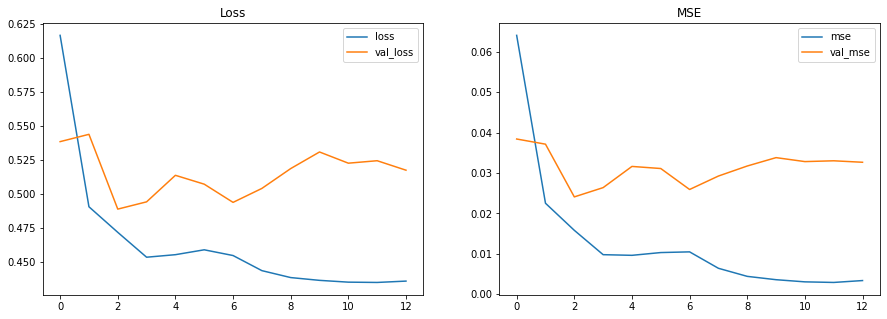

9/9 [==============================] - 0s 30ms/step - loss: 0.4889 - mse: 0.0241
Evaluation Results: [0.48892223834991455, 0.024061935022473335]
Finished for prompt 2
##################################################
Training for prompt 3......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 200)         3000000   
_________________________________________________________________
gru (GRU)                    (None, 100)               90600     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,090,701
Trainable params: 3,090,701
Non-trainable params: 0
________________________________________________________________

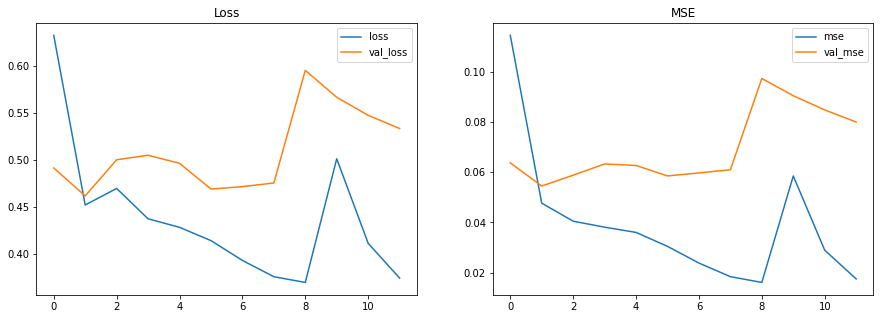

9/9 [==============================] - 0s 26ms/step - loss: 0.4615 - mse: 0.0545
Evaluation Results: [0.46153372526168823, 0.05445675924420357]
Finished for prompt 3
##################################################
Training for prompt 4......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 200)         3000000   
_________________________________________________________________
gru (GRU)                    (None, 100)               90600     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,090,701
Trainable params: 3,090,701
Non-trainable params: 0
_________________________________________________________________

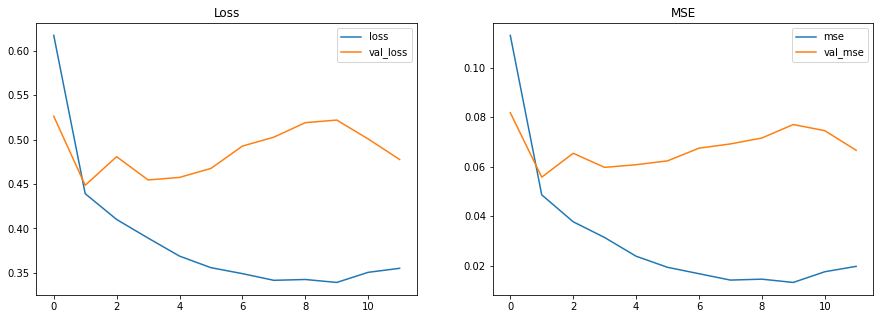

9/9 [==============================] - 0s 26ms/step - loss: 0.4485 - mse: 0.0558
Evaluation Results: [0.44848111271858215, 0.05577193945646286]
Finished for prompt 4
##################################################
Training for prompt 5......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 200)         3000000   
_________________________________________________________________
gru (GRU)                    (None, 100)               90600     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,090,701
Trainable params: 3,090,701
Non-trainable params: 0
_________________________________________________________________

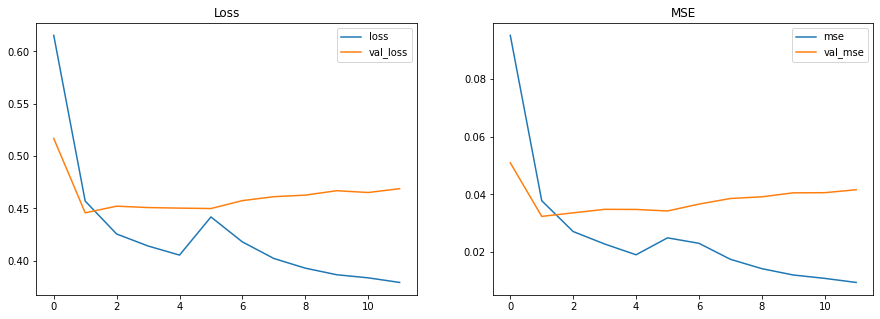

9/9 [==============================] - 0s 26ms/step - loss: 0.4459 - mse: 0.0324
Evaluation Results: [0.4458520710468292, 0.03240761160850525]
Finished for prompt 5
##################################################
Training for prompt 6......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 200)         3000000   
_________________________________________________________________
gru (GRU)                    (None, 100)               90600     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,090,701
Trainable params: 3,090,701
Non-trainable params: 0
_________________________________________________________________


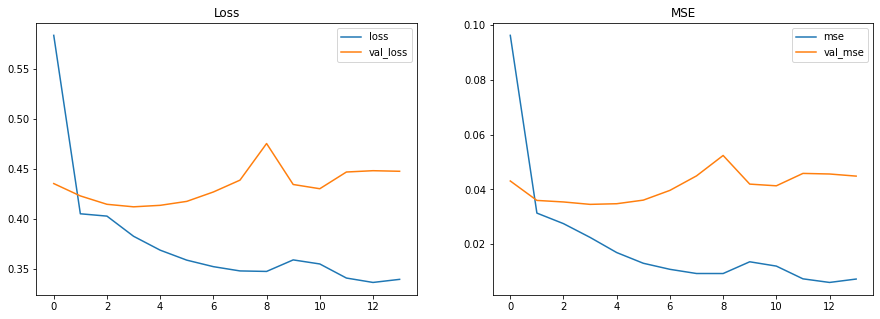

9/9 [==============================] - 0s 30ms/step - loss: 0.4120 - mse: 0.0346
Evaluation Results: [0.41201525926589966, 0.03456779941916466]
Finished for prompt 6
##################################################
Training for prompt 7......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 200)         3000000   
_________________________________________________________________
gru (GRU)                    (None, 100)               90600     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,090,701
Trainable params: 3,090,701
Non-trainable params: 0
_________________________________________________________________

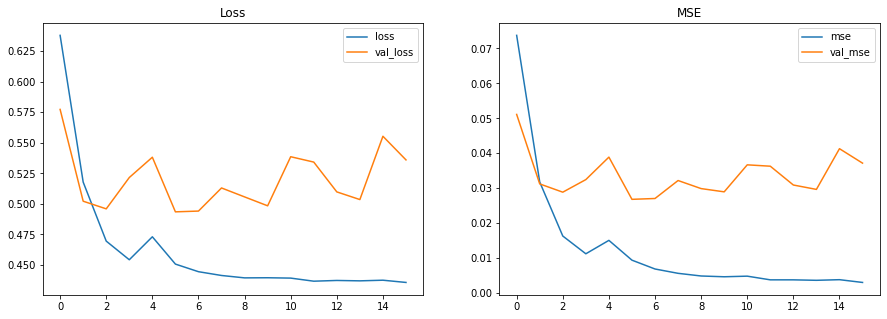

8/8 [==============================] - 0s 27ms/step - loss: 0.4935 - mse: 0.0268
Evaluation Results: [0.4935134947299957, 0.026799645274877548]
Finished for prompt 7
##################################################
Training for prompt 8......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 200)         3000000   
_________________________________________________________________
gru (GRU)                    (None, 100)               90600     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,090,701
Trainable params: 3,090,701
Non-trainable params: 0
_________________________________________________________________

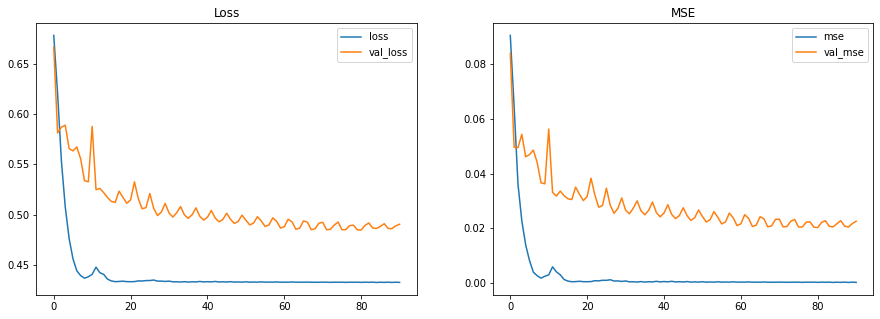

4/4 [==============================] - 0s 25ms/step - loss: 0.4845 - mse: 0.0203
Evaluation Results: [0.484546422958374, 0.020256396383047104]
Finished for prompt 8
##################################################


In [81]:
model_em_gru={}
history_em_gru={}
for i in range(1,9):

  K.clear_session()
  latent_dim=200
  print('Training for prompt '+str(i)+'......') 

  model_em_gru[i]=Sequential()
  model_em_gru[i].add(layers.Input(shape = (1,),dtype=tf.string))
  model_em_gru[i].add(text_vectorizer)
  model_em_gru[i].add(Embedding(max_features, latent_dim, input_length=sequence_length, mask_zero=True))
  model_em_gru[i].add(GRU(100))
  model_em_gru[i].add(layers.Dense(1, activation = 'sigmoid'))

  model_em_gru[i].summary()
  loss = tf.keras.losses.binary_crossentropy
  optimizer = optimizers.Adam(lr = 0.001)
  metrics=['mse']
  model_em_gru[i].compile(loss= loss, optimizer = optimizer, metrics = metrics)

  early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto',restore_best_weights=True
  )

  history_em_gru[i]=model_em_gru[i].fit(train_data[i], validation_data = val_data[i], callbacks=early_stopping, epochs = 100, verbose = 1)
  evaluate_model(model_em_gru[i],val_data[i], history_em_gru[i])
  print('Finished for prompt '+str(i)) 
  print('#'*50)

In [82]:
for i in range(1,9):
  print(QWK(model_em_gru[i],i)[0])

0.18162313865565705
0.0726135436497144
0.13503096525529956
0.3798654858638424
0.36280793521412535
0.3936238044633368
0.12176234094672944
0.16448486569720733


## 4. Using pre-trained embedding 

### Downloading glove

In [84]:
def download_file(packet_url, base_path="", extract=False):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    
    if packet_file.endswith(".tar.gz"):
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

download_file("https://github.com/shivasj/dataset-store/releases/download/v3.0/glove.6B.100d.txt.zip", base_path="embedding", extract=True)

path_to_glove_file = '/content/embedding/glove.6B.100d.txt'
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

#num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Get Vocabulary
vocabulary = text_vectorizer.get_vocabulary()
vocabulary_size = len(vocabulary)
print("Vocabulary Size:",vocabulary_size)
# Generate word index
word_index = dict(zip(vocabulary, range(vocabulary_size)))


# Prepare embedding matrix
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Vocabulary Size: 15000
Converted 11749 words (3251 misses)


### Glove + LSTM

Training for prompt 1......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 100)         1500000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 1,580,501
Trainable params: 80,501
Non-trainable params: 1,500,000
_________________________________________________________________
Epoch 1/100
34/34 [==============================] - 3s 97ms/step - loss: 0.6259 - mse: 0.0833 - val_loss: 0.9557 - val_mse: 0.1867
Epoch 2/100
34/34 [==============================] - 2s 57ms/step - loss: 0.557

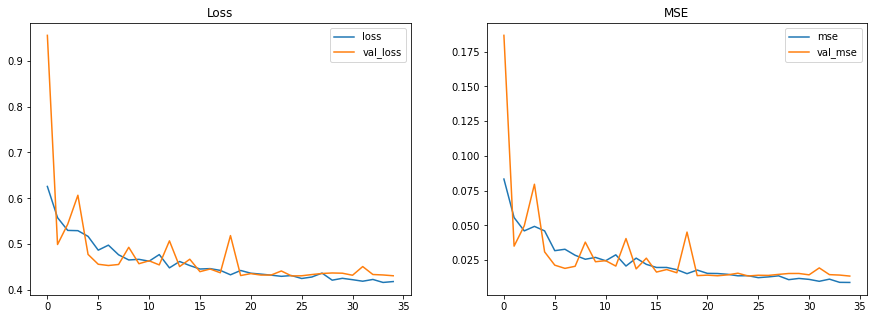

9/9 [==============================] - 0s 25ms/step - loss: 0.4306 - mse: 0.0136
Evaluation Results: [0.4305591285228729, 0.013583878055214882]
Finished for prompt 1
##################################################
Training for prompt 2......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 100)         1500000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 1,580,501
Trainable params: 80,501
Non-trainable params: 1,500,000
____________________________________________________________

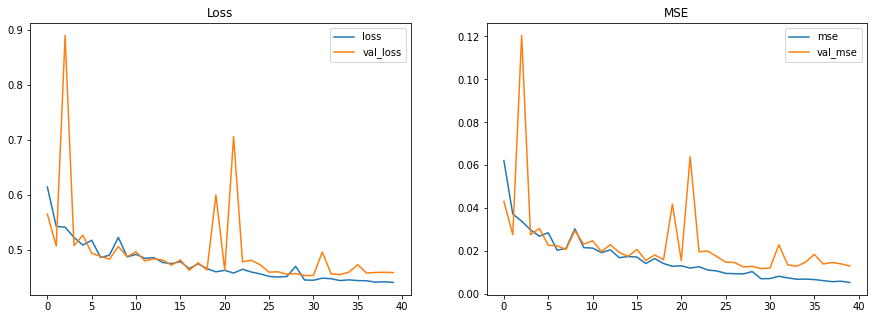

9/9 [==============================] - 0s 25ms/step - loss: 0.4539 - mse: 0.0119
Evaluation Results: [0.45385727286338806, 0.01189904659986496]
Finished for prompt 2
##################################################
Training for prompt 3......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 100)         1500000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 1,580,501
Trainable params: 80,501
Non-trainable params: 1,500,000
____________________________________________________________

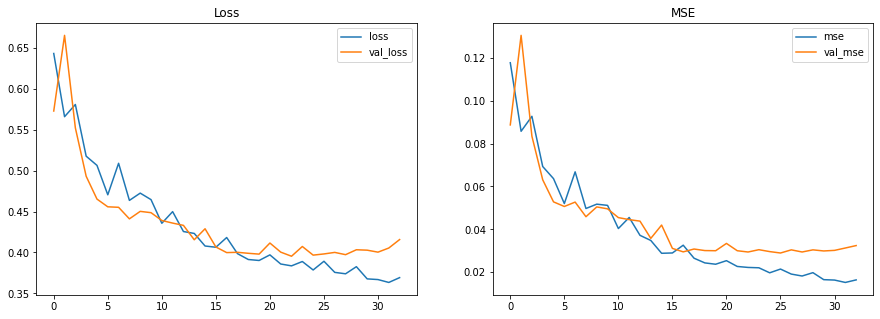

9/9 [==============================] - 0s 22ms/step - loss: 0.3954 - mse: 0.0295
Evaluation Results: [0.3953622579574585, 0.029451048001646996]
Finished for prompt 3
##################################################
Training for prompt 4......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 100)         1500000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 1,580,501
Trainable params: 80,501
Non-trainable params: 1,500,000
____________________________________________________________

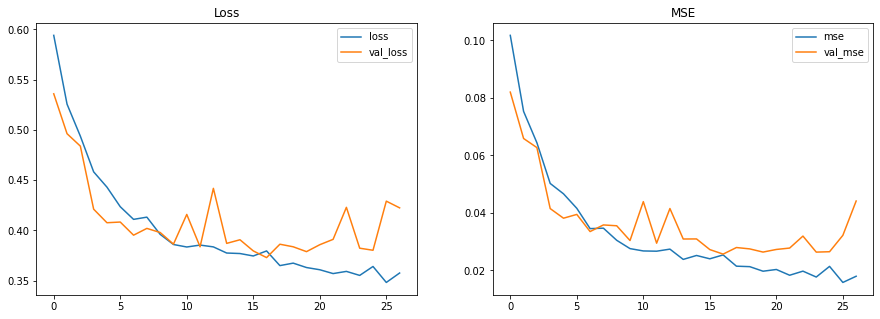

9/9 [==============================] - 0s 23ms/step - loss: 0.3731 - mse: 0.0256
Evaluation Results: [0.3730614483356476, 0.02563989907503128]
Finished for prompt 4
##################################################
Training for prompt 5......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 100)         1500000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 1,580,501
Trainable params: 80,501
Non-trainable params: 1,500,000
_____________________________________________________________

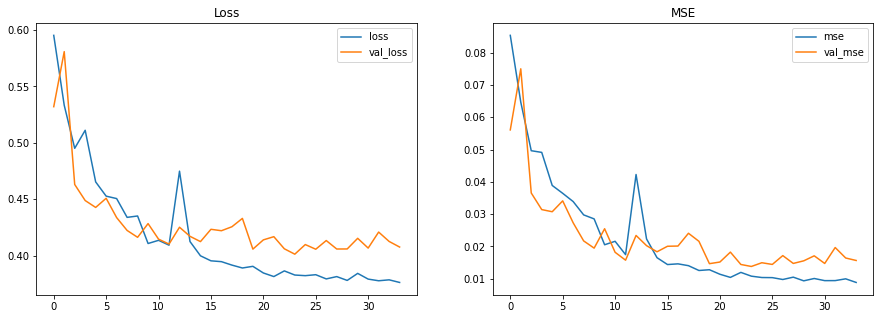

9/9 [==============================] - 0s 24ms/step - loss: 0.4012 - mse: 0.0138
Evaluation Results: [0.40120819211006165, 0.013804785907268524]
Finished for prompt 5
##################################################
Training for prompt 6......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 100)         1500000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 1,580,501
Trainable params: 80,501
Non-trainable params: 1,500,000
___________________________________________________________

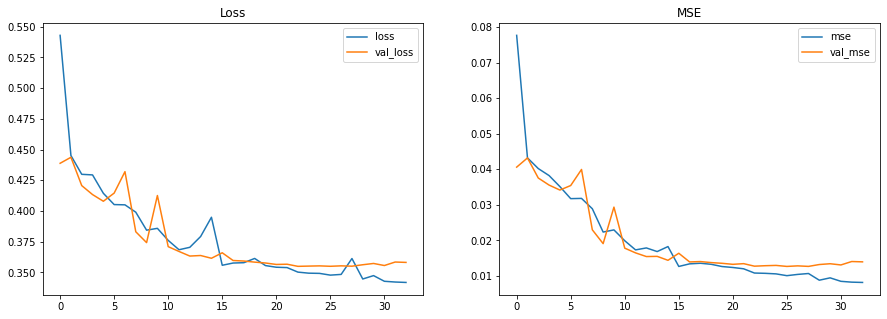

9/9 [==============================] - 0s 22ms/step - loss: 0.3550 - mse: 0.0127
Evaluation Results: [0.35499587655067444, 0.012745747342705727]
Finished for prompt 6
##################################################
Training for prompt 7......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 100)         1500000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 1,580,501
Trainable params: 80,501
Non-trainable params: 1,500,000
___________________________________________________________

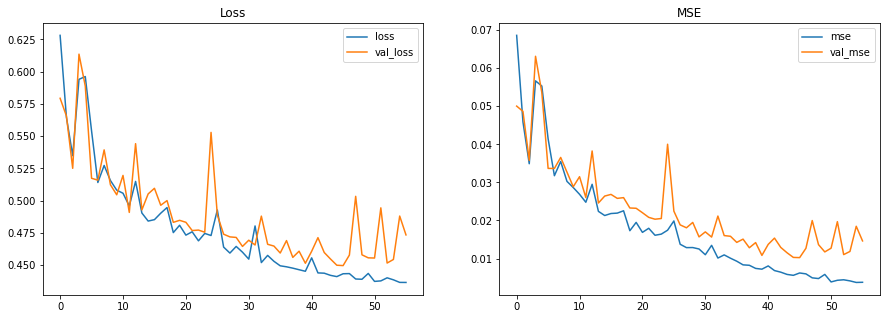

8/8 [==============================] - 0s 22ms/step - loss: 0.4496 - mse: 0.0102
Evaluation Results: [0.44959717988967896, 0.010243657976388931]
Finished for prompt 7
##################################################
Training for prompt 8......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 100)         1500000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 1,580,501
Trainable params: 80,501
Non-trainable params: 1,500,000
___________________________________________________________

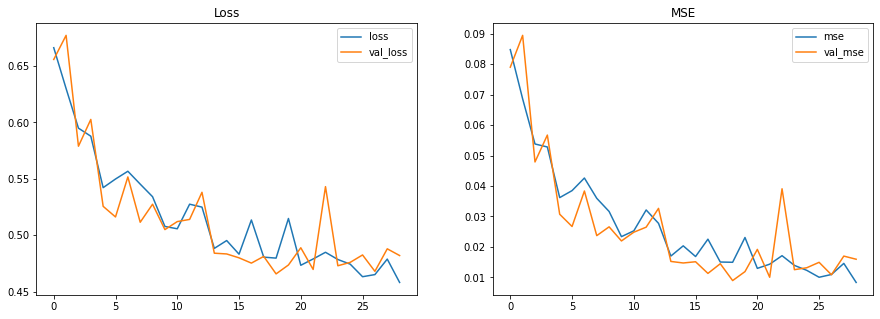

4/4 [==============================] - 0s 22ms/step - loss: 0.4657 - mse: 0.0089
Evaluation Results: [0.465657502412796, 0.008947174996137619]
Finished for prompt 8
##################################################


In [85]:
model_glo_lstm={}
history_glo_lstm={}
for i in range(1,9):
  print('Training for prompt '+str(i)+'......')
  K.clear_session()
  model_glo_lstm[i]=Sequential()
  model_glo_lstm[i].add(layers.Input(shape = (1,),dtype=tf.string))
  model_glo_lstm[i].add(text_vectorizer)
  model_glo_lstm[i].add(Embedding(max_features, 
                              embedding_dim, 
                              embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                              trainable=False,
                              name="embedding", mask_zero = True))
  model_glo_lstm[i].add(LSTM(100))
  model_glo_lstm[i].add(layers.Dense(1, activation = 'sigmoid'))

  model_glo_lstm[i].summary()
  loss = tf.keras.losses.binary_crossentropy
  optimizer = optimizers.RMSprop(learning_rate= 0.001)
  metrics=['mse']
  model_glo_lstm[i].compile(loss= loss, optimizer = optimizer, metrics = metrics)

  early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', restore_best_weights=True
  )

  history_glo_lstm[i]=model_glo_lstm[i].fit(train_data[i], validation_data = val_data[i], callbacks=early_stopping, epochs = 100, verbose = 1)
  evaluate_model(model_glo_lstm[i],val_data[i],history_glo_lstm[i])
  print('Finished for prompt '+str(i)) 
  print('#'*50)

In [86]:
for i in range(1,9):
  print(QWK(model_glo_lstm[i],i)[0])

0.32936756418284285
0.44352724094396423
0.5965298627401363
0.7725483735149286
0.7541812415465696
0.7651301660942923
0.6703013939463124
0.4203270168901527


In [98]:
for i in range(1,9):
  print(QWK(model_glo_lstm[i],i)[2].pred_scaled.mean())

0.0052417884580791
0.003186641726642847
0.012023731134831905
0.00314199342392385
0.001962477108463645
0.0003033009124919772
0.007713536731898785
0.04624713212251663


### Glove + GRU

Training for prompt 1......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 100)         1500000   
_________________________________________________________________
gru (GRU)                    (None, 1200, 64)          31872     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,541,313
Trainable params: 41,313
Non-trainable params: 1,500,000
_________________________________________________________________
Epoch 1/100
34/34 [==============================] - 5s 155ms/step - loss: 0.64

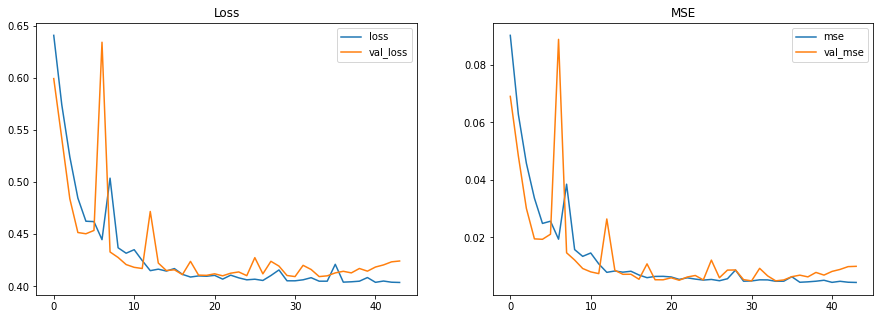

9/9 [==============================] - 0s 39ms/step - loss: 0.4094 - mse: 0.0049
Evaluation Results: [0.409392774105072, 0.0049177356995642185]
Finished for prompt 1
##################################################
Training for prompt 2......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 100)         1500000   
_________________________________________________________________
gru (GRU)                    (None, 1200, 64)          31872     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total par

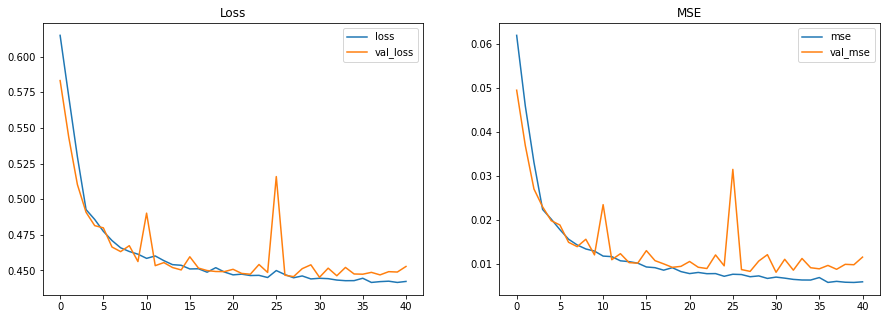

9/9 [==============================] - 0s 38ms/step - loss: 0.4452 - mse: 0.0081
Evaluation Results: [0.44519495964050293, 0.008113197050988674]
Finished for prompt 2
##################################################
Training for prompt 3......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 100)         1500000   
_________________________________________________________________
gru (GRU)                    (None, 1200, 64)          31872     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total pa

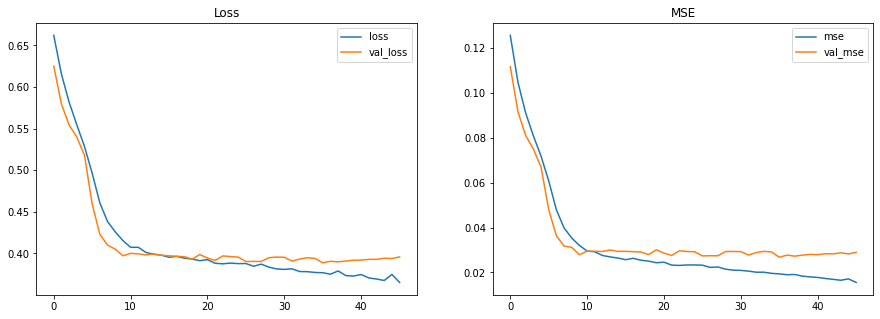

9/9 [==============================] - 0s 33ms/step - loss: 0.3887 - mse: 0.0268
Evaluation Results: [0.3887161910533905, 0.026769468560814857]
Finished for prompt 3
##################################################
Training for prompt 4......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 100)         1500000   
_________________________________________________________________
gru (GRU)                    (None, 1200, 64)          31872     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total par

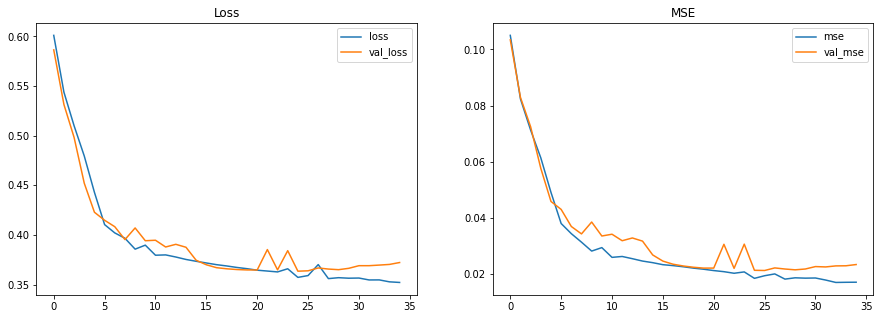

9/9 [==============================] - 0s 36ms/step - loss: 0.3635 - mse: 0.0212
Evaluation Results: [0.363473504781723, 0.021212846040725708]
Finished for prompt 4
##################################################
Training for prompt 5......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 100)         1500000   
_________________________________________________________________
gru (GRU)                    (None, 1200, 64)          31872     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total para

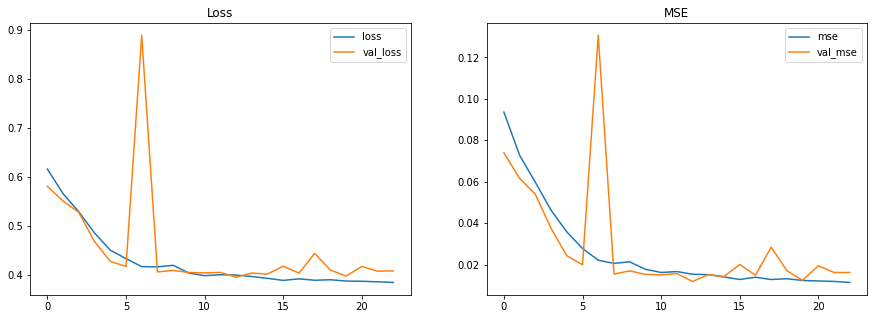

9/9 [==============================] - 0s 33ms/step - loss: 0.3961 - mse: 0.0118
Evaluation Results: [0.3961488604545593, 0.011803300119936466]
Finished for prompt 5
##################################################
Training for prompt 6......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 100)         1500000   
_________________________________________________________________
gru (GRU)                    (None, 1200, 64)          31872     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total par

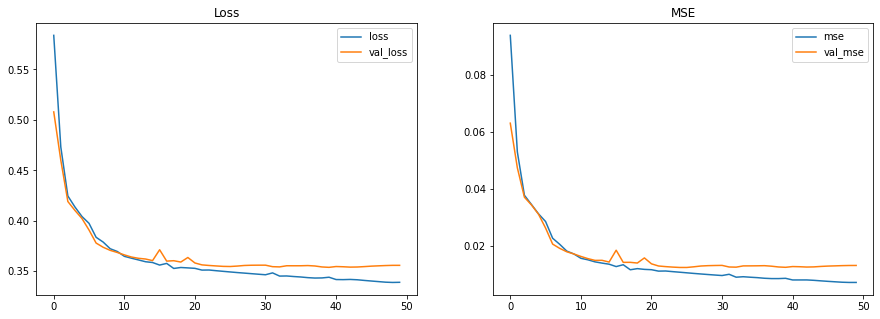

9/9 [==============================] - 0s 34ms/step - loss: 0.3538 - mse: 0.0124
Evaluation Results: [0.35383281111717224, 0.012371549382805824]
Finished for prompt 6
##################################################
Training for prompt 7......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 100)         1500000   
_________________________________________________________________
gru (GRU)                    (None, 1200, 64)          31872     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total pa

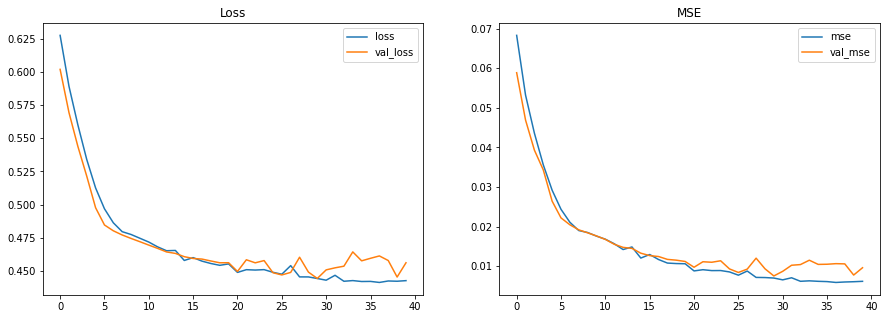

8/8 [==============================] - 0s 34ms/step - loss: 0.4444 - mse: 0.0075
Evaluation Results: [0.44436556100845337, 0.0075386930257081985]
Finished for prompt 7
##################################################
Training for prompt 8......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 100)         1500000   
_________________________________________________________________
gru (GRU)                    (None, 1200, 64)          31872     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total p

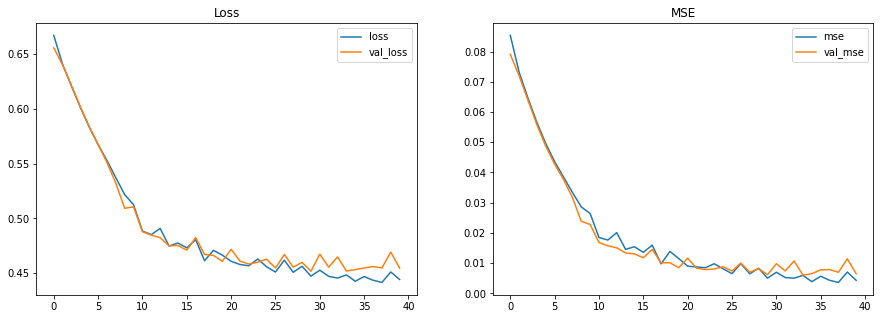

4/4 [==============================] - 0s 32ms/step - loss: 0.4516 - mse: 0.0062
Evaluation Results: [0.4516264498233795, 0.00616154121235013]
Finished for prompt 8
##################################################


In [102]:
model_glo_gru={}
history_glo_gru={}
for i in range(1,9):
  print('Training for prompt '+str(i)+'......')
  K.clear_session()
  model_glo_gru[i]=Sequential()
  model_glo_gru[i].add(layers.Input(shape = (1,),dtype=tf.string))
  model_glo_gru[i].add(text_vectorizer)
  model_glo_gru[i].add(Embedding(max_features, 
                              embedding_dim, 
                              embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                              trainable=False,
                              name="embedding", mask_zero = True))
  model_glo_gru[i].add(GRU(64, return_sequences=True))
  model_glo_gru[i].add(GRU(32))
  model_glo_gru[i].add(layers.Dense(1, activation = 'sigmoid'))

  model_glo_gru[i].summary()
  loss = tf.keras.losses.binary_crossentropy
  optimizer = optimizers.RMSprop(learning_rate= 0.0006)
  metrics=['mse']
  model_glo_gru[i].compile(loss= loss, optimizer = optimizer, metrics = metrics)

  early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', restore_best_weights=True
  )

  history_glo_gru[i]=model_glo_gru[i].fit(train_data[i], validation_data = val_data[i], callbacks=early_stopping, epochs = 100, verbose = 1)
  evaluate_model(model_glo_gru[i],val_data[i],history_glo_gru[i])#
  print('Finished for prompt '+str(i)) 
  print('#'*50)

In [103]:
for i in range(1,9):
  print(QWK(model_glo_gru[i],i)[0])

0.7799088427622685
0.599709539802124
0.6248274708268853
0.7662010329442874
0.7602351355102203
0.7912433969930922
0.6971063539551019
0.44311082669671387


In [104]:
for i in range(1,9):
  print(QWK(model_glo_gru[i],i)[2].pred_scaled.mean())

0.0005307185929268599
0.0024924916215240955
0.005217322614043951
0.0015732290921732783
0.006169943604618311
0.0009237976628355682
0.00408103596419096
0.013507649302482605


## BERT

In [111]:
train[1][0]

array(['Dear Local Newspaper, @CAPS1! I am an @NUM1 grade student at @PERSON1. I was reading your paper and I notice you had an article on how people are spending too much time on the computer and not enough time going outside, getting exercise, enjoying nature, and that it doesn\'t benifit society. i completly disagree with these comments. let me explain... Having computers definatly benifits for all students. Sometimes kids forget their text books at school. But if they have a computer, they can just google the information. That way they get there homework done, and don\'t have to take a zero. Another thing is, I am sure you have heard of a website called, study island. If you havn\'t, i\'ts a website for all the students in the @LOCATION1 to take online courses for math, reading, and science. They are time consuming, but they count for a huge chunk of our grade. So, if we get an @CAPS2 on study island we get an @CAPS2 in one of our classes.. Not only does the computer help students 

In [112]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

train_X_bert={}

val_X_bert={}

for i in range(1,9):
  train_X_bert[i]=tokenizer.batch_encode_plus(
                      train[i][0],
                      return_tensors='tf',
                      add_special_tokens = True, # add [CLS], [SEP]
                      return_token_type_ids=True,
                      padding='max_length',
                      max_length=512, # max length of the text that can go to BERT (<=512)
                      return_attention_mask = True,
                      truncation='longest_first'
                  )
  val_X_bert[i]=tokenizer.batch_encode_plus(
                      val[i][0],
                      return_tensors='tf',
                      add_special_tokens = True, # add [CLS], [SEP]
                      return_token_type_ids=True,
                      padding='max_length',
                      max_length=512, # max length of the text that can go to BERT (<=512)
                      return_attention_mask = True,
                      truncation='longest_first'
                  )


In [145]:
batch_size = 64 # You can try higher values but may run into OOM errors depending on which GPU you are using
train_shuffle_buffer_size = 800
validation_shuffle_buffer_size = 200
train_data_bert={}
val_data_bert={}
for i in range(1,9):
  train_data_bert[i]=tf.data.Dataset.from_tensor_slices((dict(train_X_bert[i]), train[i][1]))
  val_data_bert[i]=tf.data.Dataset.from_tensor_slices((dict(val_X_bert[i]), val[i][1]))

  train_data_bert[i]=train_data_bert[i].batch(batch_size)
  #train_data_bert[i]=train_data_bert[i].shuffle(train_shuffle_buffer_size)
  train_data_bert[i] = train_data_bert[i].cache().prefetch(buffer_size=train_shuffle_buffer_size)

  val_data_bert[i]=val_data_bert[i].batch(batch_size)
  #val_data_bert[i]=val_data_bert[i].shuffle(validation_shuffle_buffer_size)
  val_data_bert[i] = val_data_bert[i].cache().prefetch(buffer_size=validation_shuffle_buffer_size)

In [115]:
train_data_bert

{1: <PrefetchDataset shapes: ({input_ids: (None, 512), token_type_ids: (None, 512), attention_mask: (None, 512)}, (None, 1)), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.float64)>,
 2: <PrefetchDataset shapes: ({input_ids: (None, 512), token_type_ids: (None, 512), attention_mask: (None, 512)}, (None, 1)), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.float64)>,
 3: <PrefetchDataset shapes: ({input_ids: (None, 512), token_type_ids: (None, 512), attention_mask: (None, 512)}, (None, 1)), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.float64)>,
 4: <PrefetchDataset shapes: ({input_ids: (None, 512), token_type_ids: (None, 512), attention_mask: (None, 512)}, (None, 1)), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.float64)>,
 5: <PrefetchDataset shapes: ({input_ids: (None, 512), token_type_ids: (None, 512), attention_mask: (None, 5

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "BERT_Model_prompt_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[

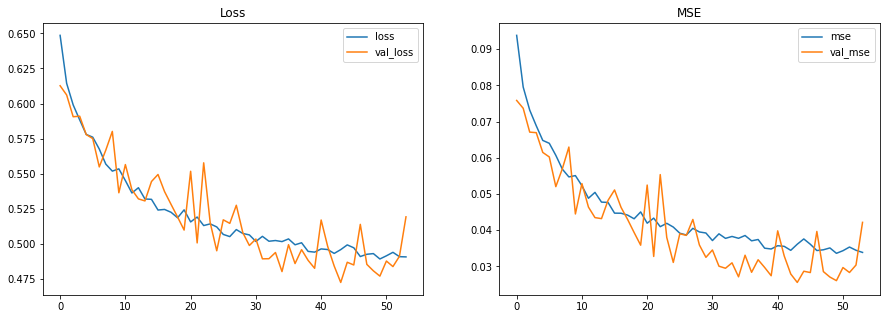

9/9 [==============================] - 10s 1s/step - loss: 0.4726 - mse: 0.0256
Evaluation Results: [0.47255954146385193, 0.025581946596503258]
Finished for prompt 1
##################################################


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "BERT_Model_prompt_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[

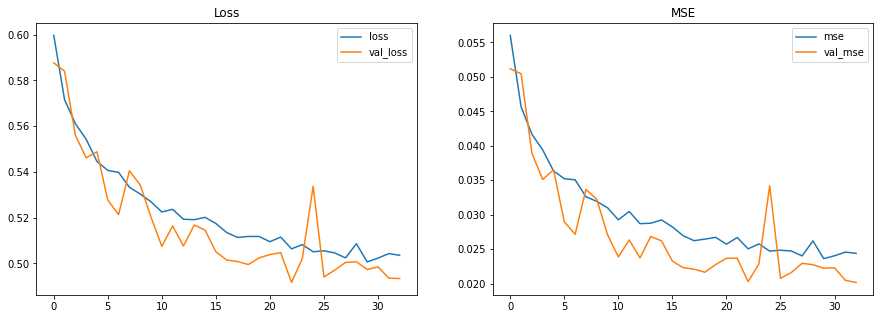

9/9 [==============================] - 10s 1s/step - loss: 0.4917 - mse: 0.0203
Evaluation Results: [0.4917014241218567, 0.020276369526982307]
Finished for prompt 2
##################################################


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "BERT_Model_prompt_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[

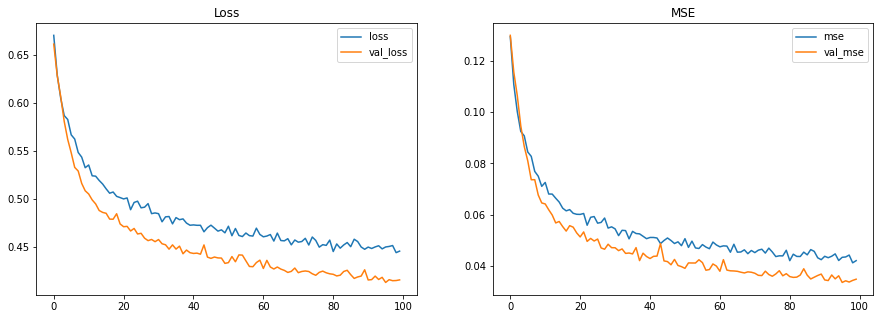

9/9 [==============================] - 9s 1s/step - loss: 0.4157 - mse: 0.0349
Evaluation Results: [0.41574621200561523, 0.03486263006925583]
Finished for prompt 3
##################################################


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "BERT_Model_prompt_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[

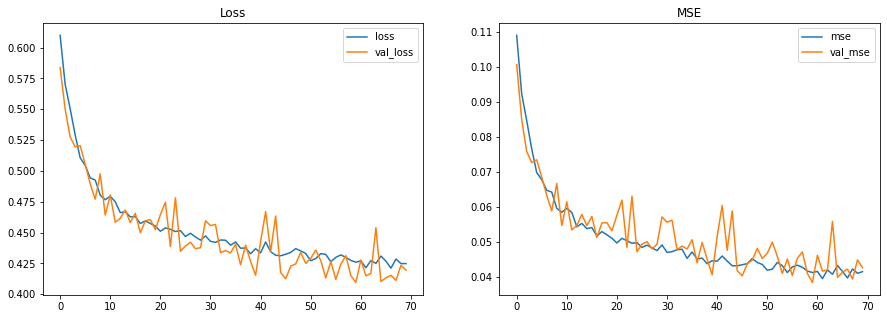

9/9 [==============================] - 9s 1s/step - loss: 0.4095 - mse: 0.0385
Evaluation Results: [0.40950560569763184, 0.03848300129175186]
Finished for prompt 4
##################################################


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "BERT_Model_prompt_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[

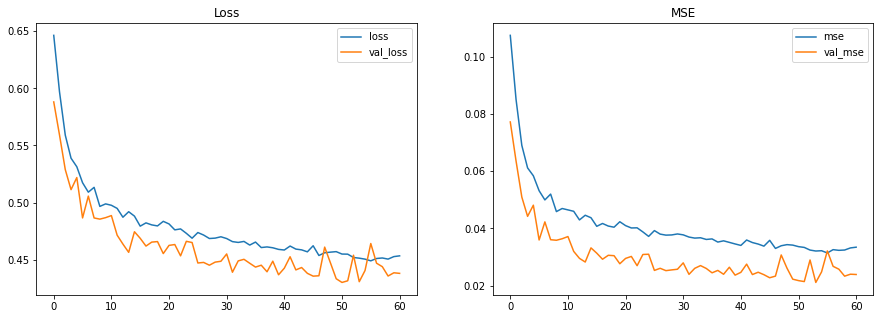

9/9 [==============================] - 10s 1s/step - loss: 0.4301 - mse: 0.0217
Evaluation Results: [0.43013131618499756, 0.021733807399868965]
Finished for prompt 5
##################################################


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "BERT_Model_prompt_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[

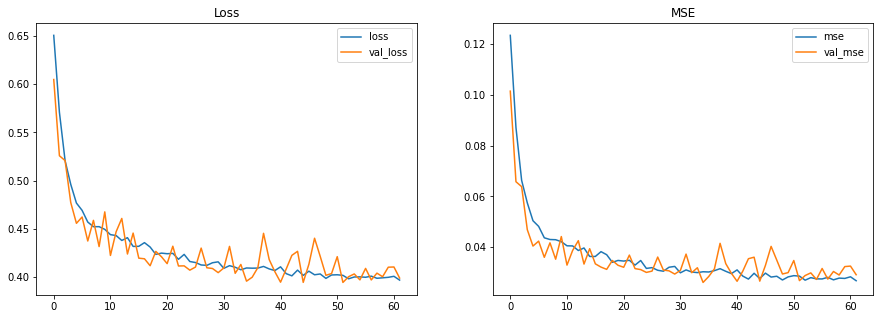

9/9 [==============================] - 10s 1s/step - loss: 0.3946 - mse: 0.0268
Evaluation Results: [0.3946117162704468, 0.026823468506336212]
Finished for prompt 6
##################################################


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "BERT_Model_prompt_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[

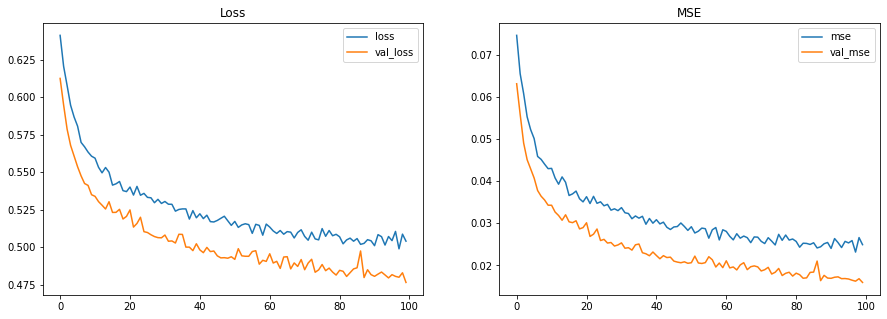

8/8 [==============================] - 8s 1s/step - loss: 0.4765 - mse: 0.0159
Evaluation Results: [0.47649237513542175, 0.015932569280266762]
Finished for prompt 7
##################################################


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "BERT_Model_prompt_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[

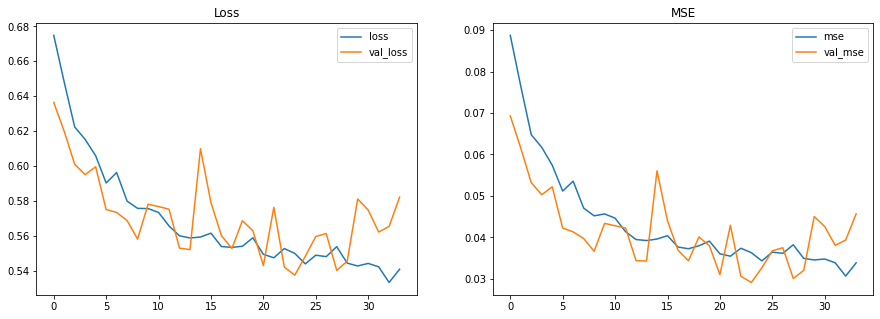

4/4 [==============================] - 3s 774ms/step - loss: 0.5375 - mse: 0.0291
Evaluation Results: [0.5375401973724365, 0.029124513268470764]
Finished for prompt 8
##################################################


In [118]:
model_bert={}
history_bert={}
for i in range(1,9):
  K.clear_session()
  max_len = 512
  input_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name = 'input_ids')
  token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name = 'token_type_ids')
  attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32, name = 'attention_mask')
  encoder = TFBertModel.from_pretrained("bert-base-uncased")
  encoder.trainable=False
  embedding = encoder(
    input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
)[1]
  embedding_flatten = layers.Flatten(name="embedding_flatten")(embedding)
  text_dropout=layers.Dropout(0.2)(embedding_flatten)
  bert_dense = layers.Dense(256, name="bert_dense", activation = 'relu')(text_dropout)
  intermediate_dense = layers.Dense(32, name = "intermediate_dense", activation = 'relu')(bert_dense)
  output = layers.Dense(1, activation = 'sigmoid')(intermediate_dense)

  inputs = {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask}
  model_bert[i] = keras.Model(inputs= inputs, outputs= output,name='BERT_Model_prompt_'+str(i))

  model_bert[i].summary()
  print('Training for prompt '+str(i)+'......')
  optimizer = optimizers.RMSprop(0.0001)
  loss = losses.binary_crossentropy
  metrics=['mse']
  model_bert[i].compile(optimizer=optimizer, loss = loss, metrics = metrics)
  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', restore_best_weights=True
)
  history_bert[i]=model_bert[i].fit(train_data_bert[i],validation_data=val_data_bert[i],callbacks=early_stopping, epochs = 100, verbose = 1)
  evaluate_model(model_bert[i],val_data_bert[i],history_bert[i])
  print('Finished for prompt '+str(i)) 
  print('#'*50)

In [153]:
for i in range(1,9):
  print(QWK_bert(model_bert[i],i)[0])

0.41045722355513714
0.43869632695292293
0.5027643268387538
0.6623692275177004
0.6701965676788117
0.4875516355922742
0.5554213249207058
0.39956383249045835


In [121]:
for i in range(1,9):
  model_bert[i].save('/content/drive/MyDrive/AC295 Final Proj/models/BERT_prompt_'+str(i))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/AC295 Final Proj/models/BERT_prompt_1/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/AC295 Final Proj/models/BERT_prompt_2/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/AC295 Final Proj/models/BERT_prompt_3/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/AC295 Final Proj/models/BERT_prompt_4/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/AC295 Final Proj/models/BERT_prompt_5/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/AC295 Final Proj/models/BERT_prompt_6/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/AC295 Final Proj/models/BERT_prompt_7/assets
INFO:tensorflow:Assets written to: /content/d

# Comparison of models

In [155]:
QWK_ffnn=[QWK(model_ffnn[i],i)[0] for i in range(1,9)]
QWK_em_lstm=[QWK(model_em_lstm[i],i)[0] for i in range(1,9)]
QWK_em_gru=[QWK(model_em_gru[i],i)[0] for i in range(1,9)]
QWK_glo_lstm=[QWK(model_glo_lstm[i],i)[0] for i in range(1,9)]
QWK_glo_gru=[QWK(model_glo_gru[i],i)[0] for i in range(1,9)]

In [156]:
QWK_bert=[QWK_bert(model_bert[i],i)[0] for i in range(1,9)]

In [157]:
QWK_summary=pd.DataFrame(columns=['Essay set ' + str(i) for i in range(1,9)])
QWK_summary.loc['FFNN']=QWK_ffnn
QWK_summary.loc['Embedding + LSTM']=QWK_em_lstm
QWK_summary.loc['Embedding + GRU']=QWK_em_gru
QWK_summary.loc['Glove + LSTM']=QWK_glo_lstm
QWK_summary.loc['Glove + GRU']=QWK_glo_gru
QWK_summary.loc['BERT']=QWK_bert
QWK_summary['Avg QWK']=QWK_summary.mean(axis=1)

In [158]:
QWK_summary

,Essay set 1,Essay set 2,Essay set 3,Essay set 4,Essay set 5,Essay set 6,Essay set 7,Essay set 8,Avg QWK
FFNN,0.062869,0.315436,0.062680,0.143706,0.094148,0.200673,-0.041600,0.022321,0.107529
Embedding + LSTM,0.098993,0.088736,0.159056,0.626845,0.612892,0.455420,0.022321,0.258776,0.290380
Embedding + GRU,0.181623,0.072614,0.135031,0.379865,0.362808,0.393624,0.121762,0.164485,0.226477
Glove + LSTM,0.329368,0.443527,0.596530,0.772548,0.754181,0.765130,0.670301,0.420327,0.593989
Glove + GRU,0.779909,0.599710,0.624827,0.766201,0.760235,0.791243,0.697106,0.443111,0.682793
BERT,0.410457,0.438696,0.502764,0.662369,0.670197,0.487552,0.555421,0.399564,0.515878
